**Question 1**

1.1

In [59]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [60]:
wnba = pd.read_csv('WNBA_team_strength.csv')
wnba.head()

,Date,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 5,Notes
0,"Tue, May 14, 2024",Indiana Fever,71,Connecticut Sun,92,Box Score,NaN
1,"Tue, May 14, 2024",Phoenix Mercury,80,Las Vegas Aces,89,Box Score,NaN
2,"Tue, May 14, 2024",Minnesota Lynx,83,Seattle Storm,70,Box Score,NaN
3,"Tue, May 14, 2024",New York Liberty,85,Washington Mystics,80,Box Score,NaN
4,"Wed, May 15, 2024",Chicago Sky,79,Dallas Wings,87,Box Score,NaN


In [61]:
#Clean Data
wnba['Date'] = pd.to_datetime(wnba['Date'], format='%a, %b %d, %Y', errors='coerce')
wnba[~wnba['PTS.1'].isna()]
wnba[~wnba['PTS'].isna()]
wnba[~wnba['Date'].isna()]
wnba.drop('Unnamed: 5', axis=1, inplace=True)
wnba.drop('Notes', axis=1, inplace=True)
wnba.rename(columns={'PTS.1': 'Home_PTS'}, inplace=True)
wnba.rename(columns={'PTS': 'Away_PTS'}, inplace=True)
wnba.drop(index=240, inplace=True)
wnba['Home_PTS'] = wnba['Home_PTS'].astype(int)
wnba['Away_PTS'] = wnba['Away_PTS'].astype(int)
wnba['diff'] = wnba['Home_PTS'] - wnba['Away_PTS']
wnba.head()

,Date,Visitor/Neutral,Away_PTS,Home/Neutral,Home_PTS,diff
0,2024-05-14,Indiana Fever,71,Connecticut Sun,92,21
1,2024-05-14,Phoenix Mercury,80,Las Vegas Aces,89,9
2,2024-05-14,Minnesota Lynx,83,Seattle Storm,70,-13
3,2024-05-14,New York Liberty,85,Washington Mystics,80,-5
4,2024-05-15,Chicago Sky,79,Dallas Wings,87,8


**1.2**

In [62]:
#Importing create_X function and change to match WNBA data
def create_X(df: pd.DataFrame) -> np.ndarray:
  """
  This function creates our design matrix with rows representing
  individual games and columns representing teams. For a given team in
  a given game, 1 means the team was home, -1 means the team is away,
  0 means the team is not playing.

  Parameters:
    df: Dataframe with match-level information

  Returns:
    Design matrix
  """

  # Dimensions of X
  n = len(df)
  p = df['Home/Neutral'].nunique()

  # Initialize with 0s
  X = np.zeros((n,p))

  # Sort teams
  team_sort = df['Home/Neutral'].sort_values().unique()

  # Assign 1s and -1s accordingly
  for i in range(len(X)):

    # Obtain team names for game i
    home_team = df['Home/Neutral'].iloc[i]
    away_team = df['Visitor/Neutral'].iloc[i]

    # Obtain corresponding indices
    home_idx = np.where(team_sort==home_team)[0][0]
    away_idx = np.where(team_sort==away_team)[0][0]

    # Assign values
    X[i,home_idx] = 1
    X[i,away_idx] = -1

  return X

In [63]:
#Create matrix and split regular season as train and playoffs as test
X = create_X(wnba)
y = np.array(wnba['diff']).reshape((-1, 1))
X_train = X[:240]
X_test = X[240:]
y_train = y[:240]
y_test = y[240:]


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(240, 12)
(240, 1)
(22, 12)
(22, 1)


**1.3**

In [65]:
#OLS without constraint
XtX = X_train.T @ X_train
theta_hat = np.linalg.inv(XtX) @ X_train.T @ y_train
theta_hat

array([[ -4.03125  ],
       [ -8.71875  ],
       [  9.28125  ],
       [ -7.09375  ],
       [ -2.8828125],
       [  0.8203125],
       [-10.2265625],
       [  7.703125 ],
       [  4.5      ],
       [ -4.78125  ],
       [  0.7421875],
       [ -5.1640625]])

In [66]:
#Metrics for OLS without constraint
print(np.linalg.det(XtX))
print(np.linalg.cond(XtX))
print(np.linalg.eigvals(XtX))

def VIF(X):
  # Computes variance inflation factor
  df_VIF = pd.DataFrame()
  df_VIF['Feature'] = X.columns
  df_VIF["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

  return df_VIF

VIF(pd.DataFrame(X_train))

1283.009713801385
1.1446261687896126e+16
[-2.37002611e-15  4.00000000e+01  4.57320508e+01  4.50000000e+01
  4.40000000e+01  4.22679492e+01  4.30000000e+01  4.57320508e+01
  4.50000000e+01  4.22679492e+01  4.30000000e+01  4.40000000e+01]


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,0,inf
1,1,inf
2,2,inf
3,3,inf
4,4,inf
5,5,inf
6,6,inf
7,7,inf
8,8,inf
9,9,inf


While an error is not thrown, the equation for theta hat shouldn't work due to it being a singular matrix and thus not invertable. A constraint needs to be applied to the matrix in order to correctly find the team strengths. The VIF function has each value being infinite, the condition is extremely large, and the determinate of the first value is 0, which are all indications that multicollinearity exists in the data. Theta_hat was only outputted due to a rounding error.

**1.4**

In [67]:
def ols_linear_constraint1(X: np.ndarray,y: np.ndarray) -> np.ndarray:
  """
  This is the special case of the function above where k = 0. In this special
  case, we can simply remove the final column of X and keep everything else
  as normal.

  Parameters:
    X: Original design matrix of team matchups
    y: Vector of score differentials

  Returns:
    Numpy array with all estimated coefficients concatenated with a 0 for the
    final team's constrained coefficient.
  """
  # Create new design matrix with final column removed
  X = X[:,:-1]

  # Proceed with typical formula for OLS solution
  XtX = X.T @ X
  theta_hat = np.linalg.inv(XtX) @ X.T @ y

  # Concatenate final team's constrained value, k=0, to estimated coefficients
  theta_hat = np.concatenate((theta_hat, np.array(0).reshape((-1,1))))

  return theta_hat


In [68]:
#Constraint 1
theta_hat_0 = ols_linear_constraint1(X_train, y_train)
theta_hat_0

array([[ 0.04802722],
       [-2.22624029],
       [ 8.18575296],
       [-4.73653166],
       [ 0.25308823],
       [ 7.21241793],
       [-3.86353181],
       [ 8.07653564],
       [10.49930631],
       [-0.53287906],
       [ 6.35392339],
       [ 0.        ]])

In [69]:
#Match team names with their respective indicies
teams = wnba['Home/Neutral'].sort_values().unique()
print(f"Number of Teams: {len(teams)}")
xnames = list(teams)[:-1]
game1_away_idx = np.where(X[0,:] == -1)[0][0]
game1_home_idx = np.where(X[0,:] == 1)[0][0]
print(f"Home Index: {game1_home_idx} vs. Away Index: {game1_away_idx}")
teams[game1_home_idx], teams[game1_away_idx]

Number of Teams: 12
Home Index: 2 vs. Away Index: 4


('Connecticut Sun', 'Indiana Fever')

In [70]:
#Statsmodels
W = np.identity(12)[:,:-1]
X_star = X_train @ W
theta_hat_W_0 = np.linalg.inv(X_star.T @ X_star) @ X_star.T @ y_train
model1 = sm.OLS(endog=y_train, exog=X_star).fit()
print(model1.summary(xname=xnames))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.345
Model:                            OLS   Adj. R-squared (uncentered):              0.314
Method:                 Least Squares   F-statistic:                              10.97
Date:                Sun, 23 Feb 2025   Prob (F-statistic):                    3.19e-16
Time:                        22:08:42   Log-Likelihood:                         -904.20
No. Observations:                 240   AIC:                                      1830.
Df Residuals:                     229   BIC:                                      1869.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [71]:
#Add the Mystics back as 0
theta_hat_1_sm = model1.params
np.concatenate((theta_hat_1_sm.reshape((-1,1)), np.array(0).reshape((-1,1))))

array([[ 0.04802722],
       [-2.22624029],
       [ 8.18575296],
       [-4.73653166],
       [ 0.25308823],
       [ 7.21241793],
       [-3.86353181],
       [ 8.07653564],
       [10.49930631],
       [-0.53287906],
       [ 6.35392339],
       [ 0.        ]])

The highest estimated team strength is the New York Liberty and the lowest estimated team strength is the Dallas Wings.

**1.5**

In [72]:
def ols_linear_constraint2(X: np.ndarray,
                           y: np.ndarray,
                           W: np.ndarray,
                           insert_idx: int = None) -> np.ndarray:
  """
  This is an implementation of our second contrains where the sum of the
  coefficients equals 0. This also implies that the average of the coefficients
  equals 0.

  Parameters:
    X: Original design matrix of team matchups
    y: Vector of score differentials
    W: Matrix encoding our coefficient constraints
    insert_idx: Integer of the index where the constrained value should be placed

  Returns:
    Numpy array with all estimated coefficients concatenated with a final constrained
    coefficient value of theta_p = -theta_1 - theta_2 - ... - theta_(p-1) for the
    final team's constrained coefficient.

  Note: For the insert_idx parameter, the location should match up with the column order
  of the constrained coefficient. By default, it is the final column in the design matrix X.
  If you add additional variables to our design matrix, insert_idx will need to be specified
  according to where the corresponding column falls in the design matrix.
  """

  X_star = X @ W
  XtX_star = X_star.T @ X_star
  theta_hat_star = np.linalg.inv(XtX_star) @ X_star.T @ y

  # For inserting the coefficient at the right spot in our coefficient vector (trivial in our first example, but with more predictors/covariates, it could get confusing...)
  if insert_idx is not None:
    # if you need to insert the constrained coefficient anywhere other than the final entry, use this...
    theta_hat = np.insert(theta_hat_star, insert_idx, -theta_hat_star[:insert_idx].sum())
  else:
    # if you need to insert the constrained coefficient into the final entry, use this...
    theta_hat = np.concatenate((theta_hat_star, -np.array(theta_hat_star.sum()).reshape((-1,1))))

  return theta_hat

In [73]:
#Constraint 2
W1 = np.identity(12)
W1 = W1[:,:-1]
W1[-1,:] = -1
theta_hat_1 = ols_linear_constraint2(X=X_train, y=y_train, W=W1)
theta_hat_1

array([[-2.39112852],
       [-4.66539603],
       [ 5.74659722],
       [-7.1756874 ],
       [-2.1860675 ],
       [ 4.77326219],
       [-6.30268755],
       [ 5.6373799 ],
       [ 8.06015057],
       [-2.9720348 ],
       [ 3.91476765],
       [-2.43915574]])

In [74]:
#Statsmodels
model2 = sm.OLS(endog=y_train, exog=X_train @ W).fit()
print(model2.summary(xname=xnames))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.345
Model:                            OLS   Adj. R-squared (uncentered):              0.314
Method:                 Least Squares   F-statistic:                              10.97
Date:                Sun, 23 Feb 2025   Prob (F-statistic):                    3.19e-16
Time:                        22:08:42   Log-Likelihood:                         -904.20
No. Observations:                 240   AIC:                                      1830.
Df Residuals:                     229   BIC:                                      1869.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

The highest estimated team strength is the New York Liberty and the lowest estimated team strength is the Dallas Wings.

**1.6**

Chosen Team: **Los Angeles Sparks**

The Los Angeles Sparks are expected to lose by 4 points when playing (or relative to) the Washington Mystics using the first type of constraint and they are expected to lose by 6 points against the "league average" team in the WNBA using the second type of constraint.

**1.7**

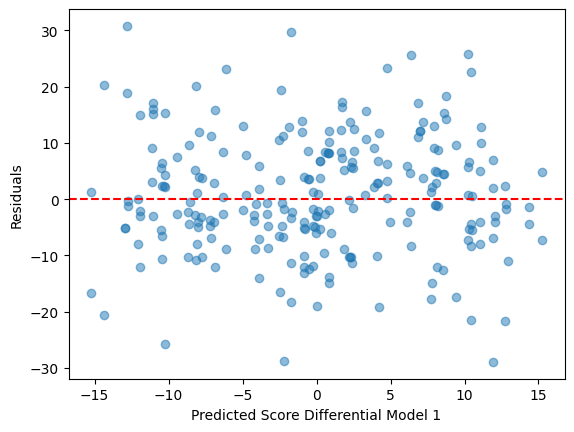

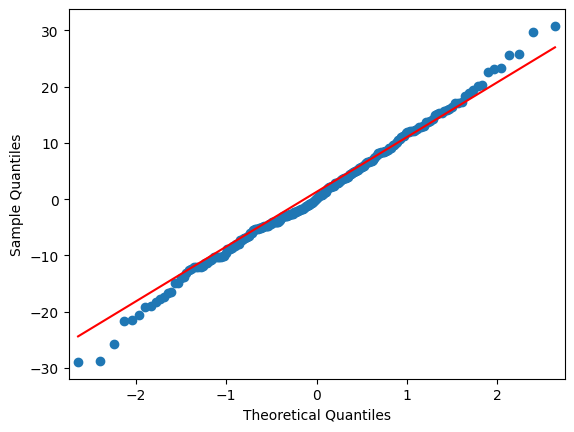

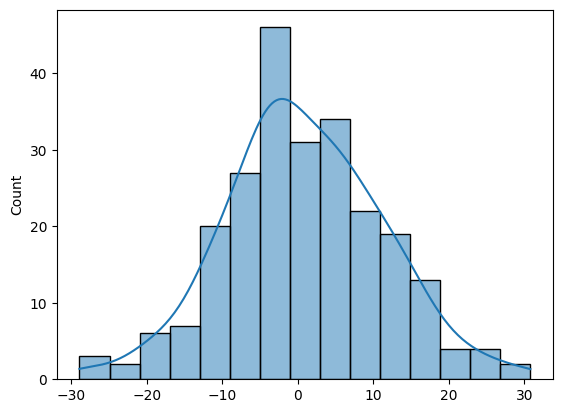

<ipython-input-75-7714a39766f0>:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


,Feature,VIF
0,0,1.819122
1,1,1.820063
2,2,1.820063
3,3,1.863541
4,4,1.819122
5,5,1.863520
6,6,1.863541
7,7,1.822155
8,8,1.820063
9,9,1.863520


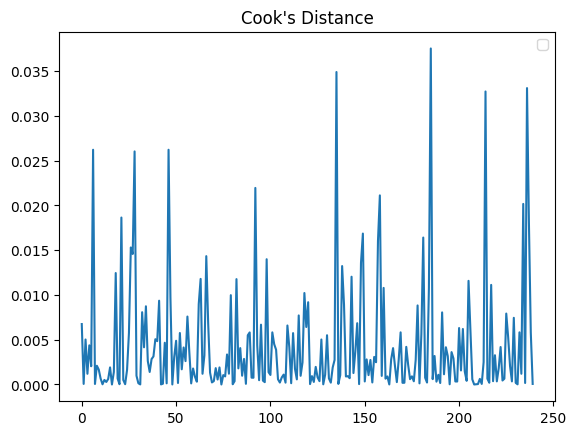

In [75]:
#Residual Plot
plt.scatter(model1.fittedvalues, model2.resid, alpha=.5)
plt.axhline(y=0, color='red', linestyle='dashed')
plt.ylabel('Residuals')
plt.xlabel('Predicted Score Differential Model 1')
plt.show()

#QQPlot
sm.qqplot(model1.resid, line='q');
plt.show()

#Histogram
sns.histplot(model1.resid, kde=True)
plt.show()

#Cook's Distance
influence = model1.get_influence()
plt.plot(influence.cooks_distance[0])
plt.title("Cook's Distance")
plt.legend(loc='best')

#VIF
VIF(pd.DataFrame(X_train@W))

Each relevant plot to check the assumptions of linearity doesn't indicate that the assumption is wrong. Residuals look like they constantly vary, the qqplot has some problems at the ends but are still normal enough, the histogram indicates a normal distribution, there are not significant outliers in the Cook's Distance graph, and VIF is low.

**1.8**

<ipython-input-76-2312e868b143>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_strengths.sort_values('Strength_1',ascending=False), y='Team', x='Strength_1',orient='h', palette=color_palette)
<ipython-input-76-2312e868b143>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_strengths.sort_values('Strength_2',ascending=False), y='Team', x='Strength_2',orient='h', palette=color_palette)


Text(0.5, 0, 'Team Strengths Relative to League Average')

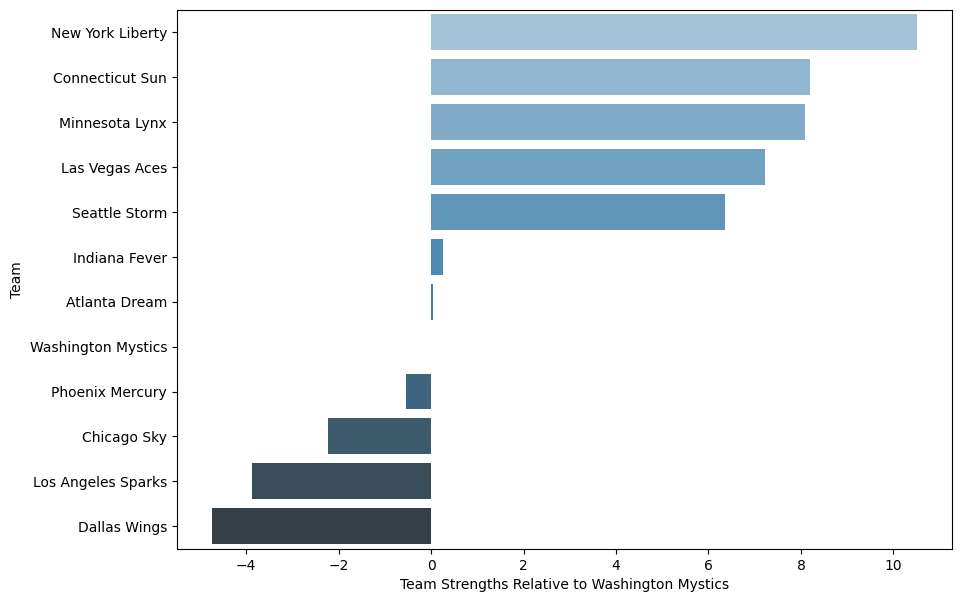

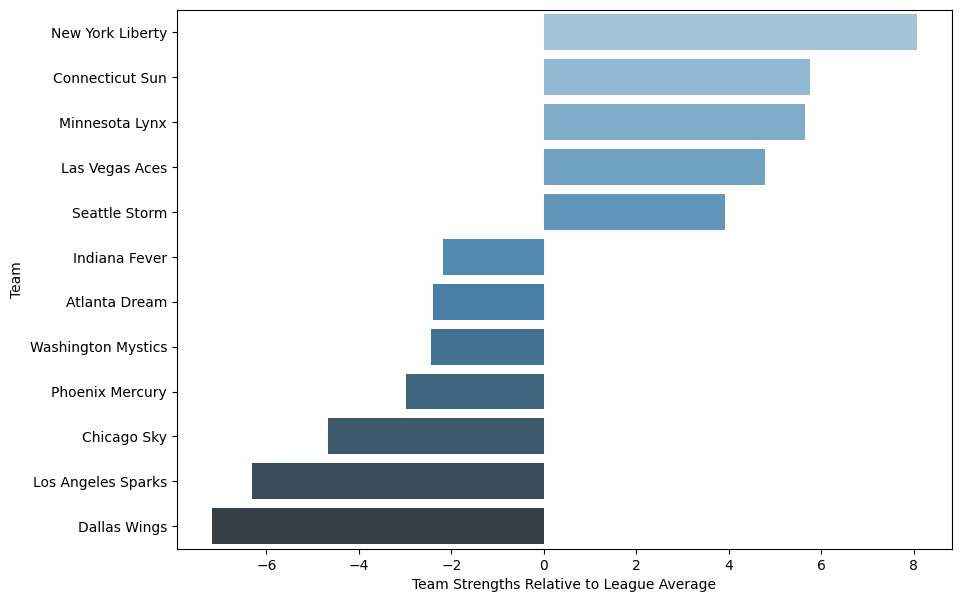

In [76]:
#Visualization of strength
df_strengths = pd.DataFrame({'Team':teams})
df_strengths['Strength_1'] = theta_hat_0
df_strengths['Strength_2'] = theta_hat_1
df_strengths.sort_values('Strength_1',ascending=False)

plt.figure(figsize=(10,7))
color_palette = sns.color_palette('Blues_d', len(df_strengths))
sns.barplot(df_strengths.sort_values('Strength_1',ascending=False), y='Team', x='Strength_1',orient='h', palette=color_palette)
plt.xlabel('Team Strengths Relative to Washington Mystics')

plt.figure(figsize=(10,7))
color_palette = sns.color_palette('Blues_d', len(df_strengths))
sns.barplot(df_strengths.sort_values('Strength_2',ascending=False), y='Team', x='Strength_2',orient='h', palette=color_palette)
plt.xlabel('Team Strengths Relative to League Average')

**1.9**

In [88]:
#Predictions based on the second model
y_pred = X_test @ theta_hat_1
res = y_test - y_pred

preds = pd.DataFrame(wnba[240:])
preds = preds.drop(columns=['Home_PTS', 'Away_PTS'])
preds['pred'] = y_pred
preds['res'] = res
preds['directionally accurate?'] = (preds['diff'] * preds['pred'] > 0)
preds.head(22)

,Date,Visitor/Neutral,Home/Neutral,diff,pred,res,directionally accurate?
241,2024-09-22,Indiana Fever,Connecticut Sun,24,7.932665,16.067335,True
242,2024-09-22,Seattle Storm,Las Vegas Aces,11,0.858495,10.141505,True
243,2024-09-22,Phoenix Mercury,Minnesota Lynx,7,8.609415,-1.609415,True
244,2024-09-22,Atlanta Dream,New York Liberty,14,10.451279,3.548721,True
245,2024-09-24,Seattle Storm,Las Vegas Aces,7,0.858495,6.141505,True
246,2024-09-24,Atlanta Dream,New York Liberty,9,10.451279,-1.451279,True
247,2024-09-25,Indiana Fever,Connecticut Sun,6,7.932665,-1.932665,True
248,2024-09-25,Phoenix Mercury,Minnesota Lynx,13,8.609415,4.390585,True
249,2024-09-29,Connecticut Sun,Minnesota Lynx,-3,-0.109217,-2.890783,True
250,2024-09-29,Las Vegas Aces,New York Liberty,10,3.286888,6.713112,True


Directionally Accurate: 16

Not Directionally Accurate: 6